In [24]:
import pandas as pd
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', None)

In [17]:
df = pd.read_csv("dataset/label.csv", sep=',')
rename_feelings = {"Happy": "positive","Sad": "negative","Surprised":"positive","Neutral":"positive","Contempt": "negative","Disgust":"negative","Fear": "negative", "Anger": "negative"}
df['emotion'] = df['emotion'].replace(rename_feelings)
df = df.sample(frac=1).reset_index(drop=True)
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
display(df.head(10))

,image,emotion,emotion_encoded
0,75.jpg,negative,0
1,49.jpg,negative,0
2,95.jpg,positive,1
3,25.jpg,negative,0
4,10.jpg,negative,0
5,111.jpg,positive,1
6,117.jpg,positive,1
7,55.jpg,positive,1
8,82.jpg,negative,0
9,2.jpg,negative,0


In [18]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = 'dataset/images/'+str(image_name)
        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))
        return t_img, self.data.iloc[idx]['emotion_encoded'].item()

In [19]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(df)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [21]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [22]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    h.remove()
    return my_embedding

In [45]:
xs = []
for t_img, label_encoder in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    #pooled = embdg.mean(dim=[2,3])
    dim = embdg.shape[1]
    flatten = embdg.squeeze().view(1, -1).detach().cpu().numpy()
    xs.append(flatten)
xs = np.concatenate(xs, axis=0)

  0%|          | 0/152 [00:00<?, ?it/s]

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(xs)

In [151]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [152]:
df['embeddings'] = X_pca.tolist()

In [153]:
df.head()

,image,emotion,emotion_encoded,embeddings
0,75.jpg,negative,0,"[-34.1399040222168, 16.53257179260254, 0.6698567271232605, -34.28062438964844, 10.189799308776855, -7.375109672546387, 1.624559760093689, 15.593060493469238]"
1,49.jpg,negative,0,"[6.313136577606201, 31.572649002075195, 83.49917602539062, 79.94110107421875, -48.1224365234375, 9.183793067932129, -22.152650833129883, 3.9817769527435303]"
2,95.jpg,positive,1,"[-25.52924919128418, -31.799840927124023, -1.0756473541259766, 36.58992004394531, -7.865789413452148, 10.950987815856934, 18.730382919311523, -43.620941162109375]"
3,25.jpg,negative,0,"[12.659807205200195, -55.720909118652344, -1.6204562187194824, 29.420679092407227, 26.159069061279297, -8.917661666870117, 86.02458953857422, 32.309478759765625]"
4,10.jpg,negative,0,"[-29.201601028442383, 5.584925174713135, 26.409255981445312, -31.530057907104492, -18.389686584472656, -34.753150939941406, 25.69066047668457, -15.659164428710938]"


In [159]:
X_train, X_test, y_train, y_test = train_test_split(df['embeddings'], df['emotion_encoded'], test_size=0.2)

In [160]:
rf_classifier = LogisticRegression(max_iter=10000, random_state=0)
#rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(np.stack(X_train), np.stack(y_train))

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [161]:
y_pred_test = rf_classifier.predict(np.stack(X_test))
print(accuracy_score(y_test, y_pred_test))

0.6451612903225806


Predicted: negative
Actual: negative


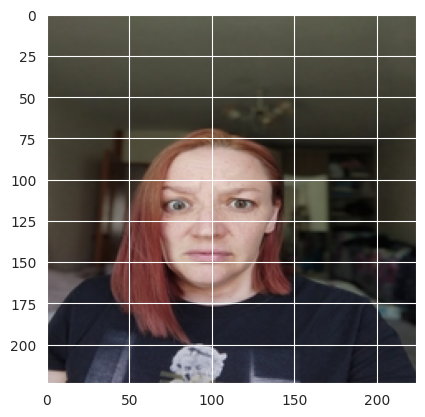

In [162]:
test_id = "11.jpg"
img = np.asarray(Image.open('dataset/images/{}'.format(test_id)))
plt.imshow(img)
img_embedding = df[df['image']==test_id]['embeddings'].to_numpy()
predict = rf_classifier.predict(np.stack(img_embedding))
actual = df[df['image']==test_id]['emotion_encoded'].to_numpy()
id2label = {0:"negative",1:"positve"}
target_names = np.array(["negative", "positve"])
print("Predicted: {}".format(id2label[predict[0]]))
print("Actual: {}".format(id2label[actual[0]]))
plt.show()

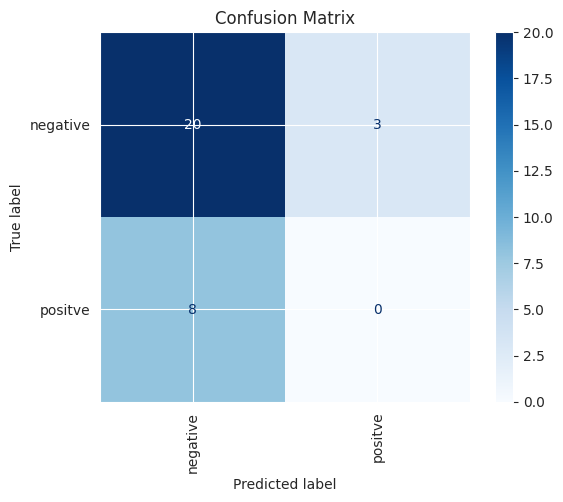

In [163]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()